In [45]:
import sys
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd


# Find project root and add 'src' folder to sys.path
project_root = Path.cwd().parents[0]  # goes from /notebooks/ to project root
src_path = project_root / 'src'
sys.path.append(str(src_path))

In [82]:
from data_fetching.fetch_yfinance import get_price_data

tickers = ['AAPL', 'TSLA', 'NVDA', "GOOG"]
start_date = '2025-01-01'
end_date = '2025-05-01'

prices = get_price_data(tickers, start_date, end_date)
print(prices.info)

[*********************100%***********************]  4 of 4 completed

<bound method DataFrame.info of Ticker            AAPL        GOOG        NVDA        TSLA
Date                                                      
2025-01-02  243.263199  190.413071  138.297272  379.279999
2025-01-03  242.774368  192.910233  144.456711  410.440002
2025-01-06  244.410416  197.734741  149.416245  411.049988
2025-01-07  241.627136  196.486160  140.127106  394.359985
2025-01-08  242.115952  195.167648  140.097122  394.940002
...                ...         ...         ...         ...
2025-04-24  208.097107  161.470001  106.430000  259.510010
2025-04-25  209.005920  163.850006  111.010002  284.950012
2025-04-28  209.864792  162.419998  108.730003  285.880005
2025-04-29  210.933395  162.059998  109.019997  292.029999
2025-04-30  212.221710  160.889999  108.919998  282.160004

[81 rows x 4 columns]>


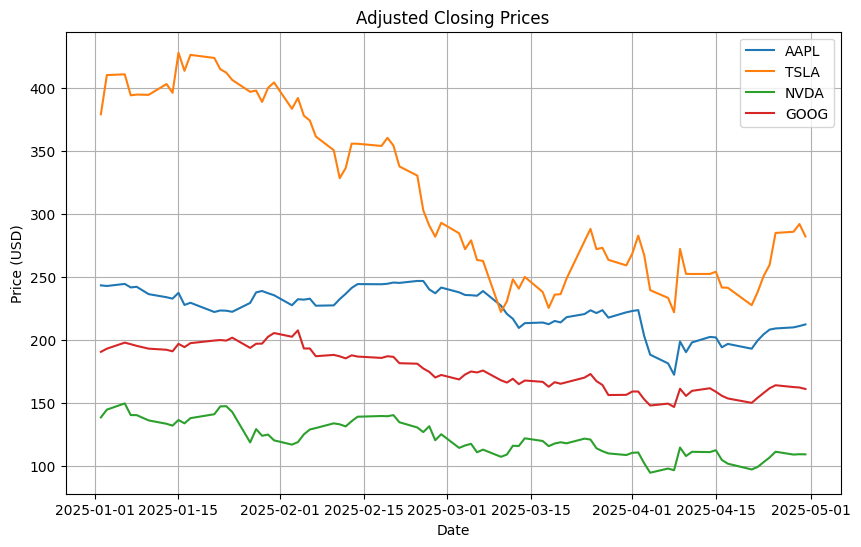

In [83]:
#Matplotlib adjusted closing price visualization
plt.figure(figsize=(10,6))
for ticker in tickers:
    plt.plot(prices.index, prices[ticker], label=ticker)

plt.title('Adjusted Closing Prices')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

This is all well and good but to do a proper portfolio optimization program, we need returns data, not prices data. That was just practice. To use Markowitz's Model, we need to understand these key concepts:
<br>
1. <b>Expected Return (Mean Return):</b> Average return you expect from an asset over time
<br>
2. <b>Risk (Covariance and Standard Deviation):</b> How much returns fluctuate. More variance = more risk.
<br>
3.<b>Covariance / Correlation:</b> How two assets move relative to each other. If they move perfectly together (correlation = 1), diversification benefits are low. If they move differently or opposite (correlation < 1), risk can be reduced by combining them.
<br>
4. <b>Porfolio Return:</b> Weighted sum of expected returns
<br>
5. <b>Portfolio Variance:</b> Weighted sum of variances and covariances, capturing total risk.
<br>
<br>
Now that we understand those key concepts, we need the following data:
<br>
- Returns data, not prices — Returns measure percentage change day-to-day (or whatever frequency you choose).
<br>
- Mean returns vector — average return per asset.
<br>
- Covariance matrix — measures how asset returns move together.

In [84]:
#Calculations
returns = prices.pct_change().dropna() #Percentage change in prices of chosen stocks day to day, drops NaN (first row)
mean_returns = returns.mean() #Mean Returns
cov_matrix = returns.cov() #CoVariance Matrix
print(returns)
print(mean_returns)
print(cov_matrix)

Ticker          AAPL      GOOG      NVDA      TSLA
Date                                              
2025-01-03 -0.002009  0.013114  0.044538  0.082156
2025-01-06  0.006739  0.025009  0.034332  0.001486
2025-01-07 -0.011388 -0.006314 -0.062170 -0.040603
2025-01-08  0.002023 -0.006710 -0.000214  0.001471
2025-01-10 -0.024104 -0.011362 -0.029976 -0.000506
...              ...       ...       ...       ...
2025-04-24  0.018426  0.023776  0.036218  0.034976
2025-04-25  0.004367  0.014740  0.043033  0.098031
2025-04-28  0.004109 -0.008728 -0.020539  0.003264
2025-04-29  0.005092 -0.002216  0.002667  0.021513
2025-04-30  0.006108 -0.007220 -0.000917 -0.033798

[80 rows x 4 columns]
Ticker
AAPL   -0.001284
GOOG   -0.001831
NVDA   -0.001915
TSLA   -0.002345
dtype: float64
Ticker      AAPL      GOOG      NVDA      TSLA
Ticker                                        
AAPL    0.000866  0.000464  0.000732  0.001026
GOOG    0.000464  0.000555  0.000739  0.000946
NVDA    0.000732  0.000739  0.002146

Now that we have calculated these numbers, we will build a basic model that maximizes <b>sharpe ratio</b>. 
<br>
<br>
### **What is Sharpe Ratio?**
Sharpe Ratio = (Portfolio Return - Risk Free Rate)/Portfolio Risk (or Standard Deviation)
<br>
<br>
-Portfolio Return: How much your portfolio is expected to grow
<br>
-Risk-Free Rate: What you'd earn doing nothing risky (e.g., government bonds)
<br>
-Portfolio Risk: How much the returns bounce around (volatility)
<br>
The Sharpe ratio measures how much return you're getting for each unit of risk you take.
<br>
| Sharpe Ratio | Interpretation           |
| ------------ | ------------------------- |
| < 1.0        | Poor risk-adjusted return |
| \~1.0        | Acceptable                |
| > 1.0        | Good                      |
| > 2.0        | Very Good                 |
| > 3.0        | Excellent                 |

### **Volatility Classification (Annualized Standard Deviation)**  
*(For stocks/portfolios, based on historical equity markets)*  

| Volatility Range  | Classification       | Interpretation                          | Example Assets                          |
|-------------------|----------------------|-----------------------------------------|-----------------------------------------|
| **< 10%**         | Very Low Volatility  | Cash-like stability                    | T-bills, utility stocks, low-vol ETFs  |
| **10–15%**        | Low Volatility       | Defensive, low sensitivity to markets  | Consumer staples, blue-chip dividends  |
| **15–20%**        | Moderate Volatility  | Typical diversified portfolio          | S&P 500, balanced mutual funds        |
| **20–30%**        | High Volatility      | Aggressive growth/sector risk          | Tech stocks, small-caps               |
| **30–50%**        | Very High Volatility | Speculative, large swings              | Meme stocks, crypto, biotech          |
| **> 50%**         | Extreme Volatility   | Casino-level risk                      | Penny stocks, 3x leveraged ETFs       |

### **Notes:**  
- **S&P 500** historically: ~15–20%  
- **Bonds**: 5–10% | **Crypto (BTC)**: 60–100%  
- High volatility (>25%) = common for single stocks, rare for diversified portfolios.  



In [98]:
import numpy as np

#Sharpe Ratio Function
def calc_sharpe_ratio(total_investment, tickers, weights, mean_returns, cov_matrix, trading_days, risk_free_rate=0.044):
    portfolio_return = np.dot(weights, mean_returns) * trading_days #np.dot used for multiplication, if array are both 2D then it does matrix multiplication. already annualized.
    
    portfolio_volatility = (np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(trading_days))*100 #percentage
    
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_volatility #calculates Sharpe Ratio

    weights_df = pd.DataFrame(data=weights, index=tickers, columns=['Weight']) #how much weight each asset has

    weights_df['Weight'] = weights_df['Weight'] * 100  # convert to percent

    # Calculate dollar allocation per stock
    weights_df['USD Allocation'] = weights_df['Weight'] * total_investment

    # Reorder columns for clarity
    weights_df = weights_df[['Weight', 'USD Allocation']]

    weights_df['Projected Return ($)'] = portfolio_return*weights_df['USD Allocation']
    weights_df = weights_df[['Weight', 'USD Allocation', 'Projected Return ($)']]

    total_projected_return_usd = weights_df['Projected Return ($)'].sum()


    print(f"Sharpe Ratio: {sharpe_ratio:.4f}")

    
    if sharpe_ratio < 1.0:
        print("Sharpe Ratio Intepretation: Poor risk adjusted return")
    elif sharpe_ratio == 1.0:
        print("Sharpe Ratio Intepretation: Acceptable")
    elif sharpe_ratio > 1.0:
        print("Sharpe Ratio Intepretation: Good")
    elif sharpe_ratio > 2.0:
        print("Sharpe Ratio Intepretation: Very good")
    elif sharpe_ratio > 3.0:
        print("Sharpe Ratio Intepretation: Excellent")
    
    if portfolio_volatility < 10:
        print("Volatility Intepretation: Cash-like stability")
    elif portfolio_volatility < 15:
        print("Volatility Intepretation: Defensive, low sensitivity to markets")
    elif portfolio_volatility < 20:
        print("Volatility Intepretation: Typical diversified portfolio")
    elif portfolio_volatility < 30:
        print("Volatility Intepretation: Aggressive growth/sector risk ")
    elif portfolio_volatility < 50:
        print("Volatility Intepretation: Speculative, large swings")
    elif portfolio_volatility > 50:
        print("Volatility Intepretation: Casino-level risk")

    print(f"Portfolio Return: {portfolio_return:.4f}")

    print(f"Portfolio Volatility: {portfolio_volatility:.4f}%")

    if portfolio_volatility < 10:
        print("Volatility Intepretation: Cash-like stability")
    elif portfolio_volatility < 15:
        print("Volatility Intepretation: Defensive, low sensitivity to markets")
    elif portfolio_volatility < 20:
        print("Volatility Intepretation: Typical diversified portfolio")
    elif portfolio_volatility < 30:
        print("Volatility Intepretation: Aggressive growth/sector risk ")
    elif portfolio_volatility < 50:
        print("Volatility Intepretation: Speculative, large swings")
    elif portfolio_volatility > 50:
        print("Volatility Intepretation: Casino-level risk")
    
    print("Portfolio Weights (%):")
    
    print(weights_df)

    print(f"Total Projected Returns ($): {total_projected_return_usd:.2f}")



In [99]:
#We will now call the function here.
trading_days = prices.shape[0]
total_investment = 1000 #USD amount we are investing

n = len(mean_returns)
weights = np.array([1/n] * n) #How much of each stock we are buying essentially. (assuming we buy equal amounts of each stock)

calc_sharpe_ratio(total_investment, tickers, weights, mean_returns, cov_matrix, trading_days)

Sharpe Ratio: -0.0065
Sharpe Ratio Intepretation: Poor risk adjusted return
Volatility Intepretation: Aggressive growth/sector risk 
Portfolio Return: -0.1494
Portfolio Volatility: 29.6662%
Volatility Intepretation: Aggressive growth/sector risk 
Portfolio Weights (%):
      Weight  USD Allocation  Projected Return ($)
AAPL    25.0         25000.0          -3733.962397
TSLA    25.0         25000.0          -3733.962397
NVDA    25.0         25000.0          -3733.962397
GOOG    25.0         25000.0          -3733.962397
Total Projected Returns ($): -14935.85
